# 1. Imports

In [1]:
#!pip install tensorflow tensorflow-gpu opencv-python matplotlib
#!pip list

In [2]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
    
tf.config.list_physical_devices('GPU')


[]

# 2. Load Data

In [4]:
data_dir = 'data' 
data = tf.keras.utils.image_dataset_from_directory('data', batch_size=16, color_mode="grayscale")
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

Found 878 files belonging to 7 classes.


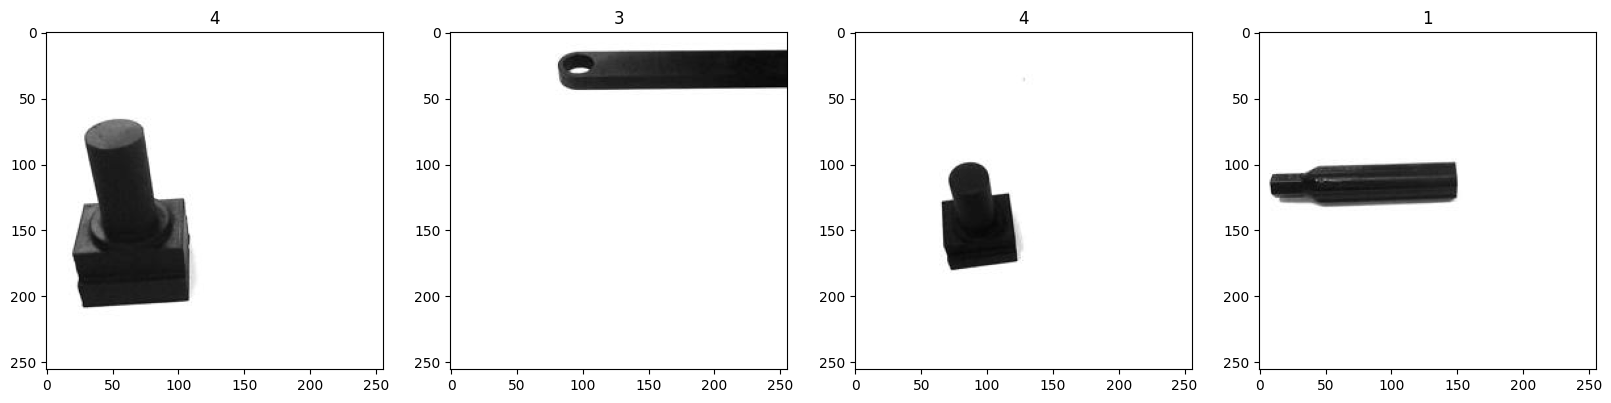

In [5]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int), cmap="gray")
    ax[idx].title.set_text(batch[1][idx])

# 3. Scale Data

In [6]:
data = data.map(lambda x,y: (x/255, y))   #255
data.as_numpy_iterator().next()


(array([[[[1.],
          [1.],
          [1.],
          ...,
          [1.],
          [1.],
          [1.]],
 
         [[1.],
          [1.],
          [1.],
          ...,
          [1.],
          [1.],
          [1.]],
 
         [[1.],
          [1.],
          [1.],
          ...,
          [1.],
          [1.],
          [1.]],
 
         ...,
 
         [[1.],
          [1.],
          [1.],
          ...,
          [1.],
          [1.],
          [1.]],
 
         [[1.],
          [1.],
          [1.],
          ...,
          [1.],
          [1.],
          [1.]],
 
         [[1.],
          [1.],
          [1.],
          ...,
          [1.],
          [1.],
          [1.]]],
 
 
        [[[1.],
          [1.],
          [1.],
          ...,
          [1.],
          [1.],
          [1.]],
 
         [[1.],
          [1.],
          [1.],
          ...,
          [1.],
          [1.],
          [1.]],
 
         [[1.],
          [1.],
          [1.],
          ...,
      

# 4. Split Data

In [7]:
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2)
test_size = int(len(data) * 0.1)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

# One-hot encode the target labels
num_classes = 7

train = train.map(lambda x, y: (x, tf.one_hot(tf.cast(y, tf.int32), num_classes)))
val = val.map(lambda x, y: (x, tf.one_hot(tf.cast(y, tf.int32), num_classes)))
test = test.map(lambda x, y: (x, tf.one_hot(tf.cast(y, tf.int32), num_classes)))


# 5. Build Deep Learning Model

In [8]:
# Create the model
model = Sequential()

# First convolution
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Second convolution
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Third convolution
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Fourth convolution
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Fifth convolution
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

# Compile the model
optimizer = RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                        

# 6. Train

In [9]:
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

hist = model.fit(train, epochs=50, validation_data=val, callbacks=[early_stopping])


Epoch 1/50
38/38 [==============================] - 163s 4s/step - loss: 1.1840 - accuracy: 0.5789 - val_loss: 1.8818 - val_accuracy: 0.1307
Epoch 2/50
38/38 [==============================] - 146s 4s/step - loss: 0.5247 - accuracy: 0.8207 - val_loss: 1.7586 - val_accuracy: 0.4318
Epoch 3/50
38/38 [==============================] - 147s 4s/step - loss: 0.2867 - accuracy: 0.8914 - val_loss: 1.5013 - val_accuracy: 0.7727
Epoch 4/50
38/38 [==============================] - 139s 4s/step - loss: 0.2102 - accuracy: 0.9260 - val_loss: 1.2824 - val_accuracy: 0.9489
Epoch 5/50
38/38 [==============================] - 113s 3s/step - loss: 0.1372 - accuracy: 0.9622 - val_loss: 0.9954 - val_accuracy: 0.9489
Epoch 6/50
38/38 [==============================] - 142s 4s/step - loss: 0.1233 - accuracy: 0.9605 - val_loss: 0.7993 - val_accuracy: 0.9659
Epoch 7/50
38/38 [==============================] - 112s 3s/step - loss: 0.0952 - accuracy: 0.9638 - val_loss: 0.6643 - val_accuracy: 0.9261
Epoch 8/50
38

# 7. Plot Performance

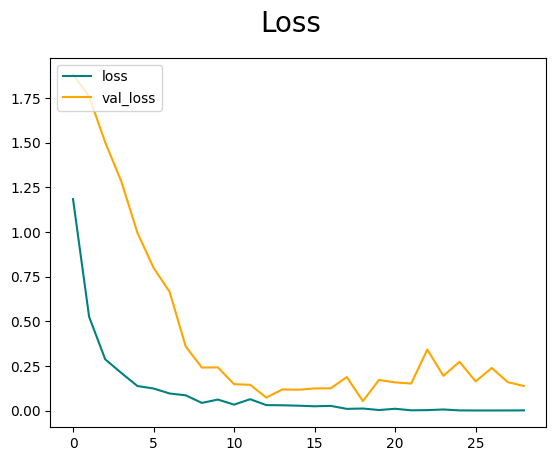

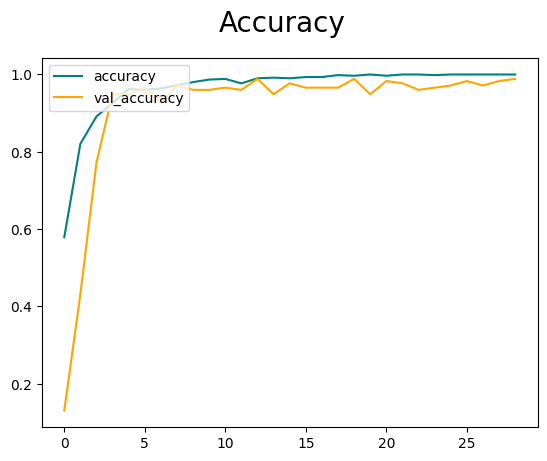

In [10]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 8. Evaluate

In [11]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 1s 781ms/step


In [12]:
print(pre.result().numpy(), re.result().numpy(), acc.result().numpy())

0.9625 0.9625 0.9892857


# 9. Test

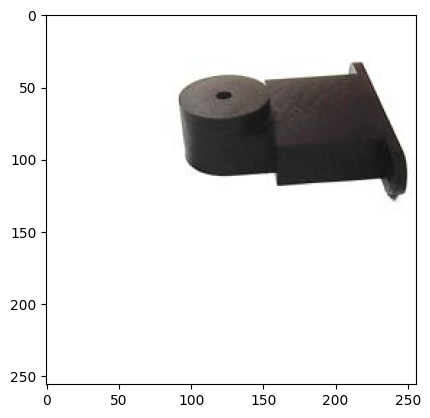

InvalidArgumentError: Graph execution error:

Detected at node 'sequential/conv2d/Relu' defined at (most recent call last):
    File "c:\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\oscar\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Python310\lib\site-packages\traitlets\config\application.py", line 982, in launch_instance
      app.start()
    File "C:\Users\oscar\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\oscar\AppData\Roaming\Python\Python310\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Python310\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "c:\Python310\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "c:\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\oscar\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\oscar\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\oscar\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\oscar\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\oscar\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\oscar\AppData\Roaming\Python\Python310\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "c:\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "c:\Python310\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\oscar\AppData\Local\Temp\ipykernel_8556\323546290.py", line 5, in <module>
      prediction = model.predict(resize)
    File "c:\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Python310\lib\site-packages\keras\engine\training.py", line 2382, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\Python310\lib\site-packages\keras\engine\training.py", line 2169, in predict_function
      return step_function(self, iterator)
    File "c:\Python310\lib\site-packages\keras\engine\training.py", line 2155, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Python310\lib\site-packages\keras\engine\training.py", line 2143, in run_step
      outputs = model.predict_step(data)
    File "c:\Python310\lib\site-packages\keras\engine\training.py", line 2111, in predict_step
      return self(x, training=False)
    File "c:\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Python310\lib\site-packages\keras\engine\training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Python310\lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Python310\lib\site-packages\keras\engine\sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Python310\lib\site-packages\keras\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Python310\lib\site-packages\keras\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Python310\lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Python310\lib\site-packages\keras\layers\convolutional\base_conv.py", line 321, in call
      return self.activation(outputs)
    File "c:\Python310\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "c:\Python310\lib\site-packages\keras\backend.py", line 5396, in relu
      x = tf.nn.relu(x)
Node: 'sequential/conv2d/Relu'
convolution input must be 4-dimensional: [32,256,3]
	 [[{{node sequential/conv2d/Relu}}]] [Op:__inference_predict_function_10557]

In [16]:
img = cv2.imread('test_ (7).jpg')
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()
prediction = model.predict(resize)
index = np.argmax(prediction)
print(index+1)
print(prediction[0][index])

# 10. Save the Model

In [17]:
model.save(os.path.join('models','imageclassifier5.h5'))

# 11. Confusion Matrix

In [18]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

# Load the model from the .h5 file
#model = load_model('imageclassifier3.h5')
optimizer = RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

5/5 [==============================] - 4s 690ms/step


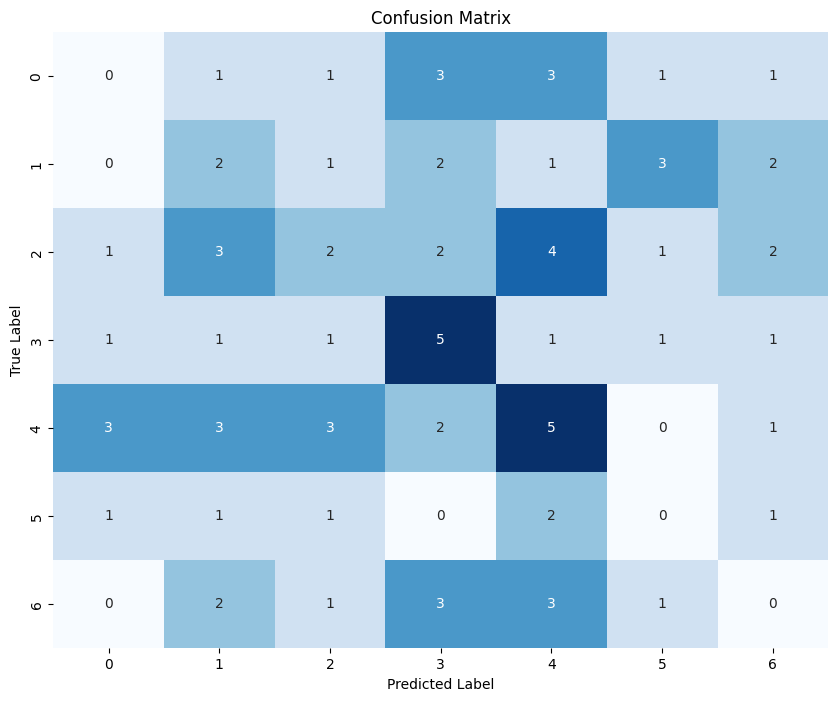

In [19]:

#test_data = test.map(lambda x, y: x)
test_labels = test.map(lambda x, y: tf.argmax(y, axis=-1))
test_data = test.map(lambda x, y: (tf.image.resize(x, (256, 256)), y))
#test_labels = test.map(lambda x, y: tf.argmax(y, axis=-1)).unbatch()

predictions = model.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)

test_labels = np.concatenate(list(test_labels.as_numpy_iterator()), axis=0)

cm = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()